In [1]:
import os
import urllib.request
import csv
import nltk
import pandas as pd 
import re
try: 
    from BeautifulSoup import BeautifulSoup
except ImportError:
        from bs4 import BeautifulSoup ,NavigableString

### Part 1: Data Collection

- Identify the URLs and category labels for all news articles listed on the website:
http://mlg.ucd.ie/modules/COMP41680/archive/index.html

For this part I have implmented following functions to get URLs and category labels. For scrapping the URLs and labels
I have used [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) which is a Python library for pulling data out of HTML and XML files.


In [2]:
# This function will create csv file with headings to store URLs and catgeory labels
def create_csvfile (file_loc, headings): 
    with open(file_loc, "w",newline='') as write_file: 
        f = csv.writer(write_file)
        f.writerow(headings)
    write_file.close()

# This Funciton will create a text file to save the body of articles in second task of part 1
def create_txtfile (file_loc): 
    with open(file_loc, "w",newline='') as write_file: 
        write_file.close()

# This function will scrap the all the URls and thier relevant categories using BeautifulSoup
# After analysing the link I pass month as array parameter and loop through the main link and then extract the inner category 
#and URLs
def get_URLs_category(news_url): 

    months = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
    for month in months:
        link = "http://mlg.ucd.ie/modules/COMP41680/archive/month-"+month +"-2017.html"
        response = urllib.request.urlopen(link)
        html = response.read().decode()
        parsed_html = BeautifulSoup(html,"lxml")
       
        with open(news_url, 'a',newline='') as news_file:
            csvwriter = csv.writer(news_file)
            for td in parsed_html.body.findAll('td',{"class":lambda class_: class_ in ("category","title")}):
                # ignore the N/A values
                for category in td.parent.find_all("td", text=re.compile("^((?!N\/A).)*$")):
                    category2=td.parent.find("td",attrs={"class":"category"}).text
                    if(not td.parent.find("i")):
                        url=td.parent.find("a")["href"]
                    csvwriter.writerow([category2,url])
        news_file.close()     

# This function is ectracting only body part of Article by comparing first and last tag in HTML                
def between(cur, end):
    while cur and cur != end:
        if isinstance(cur, NavigableString):
            text = cur.strip()
            if len(text):
                yield text
        cur = cur.next_element

    
    
    

In [3]:
# Function call to create csv file for saving URLS
news_url="news_data.csv"
headings =["category","Url"]
create_csvfile(news_url, headings)


In [4]:
# Function to get and identify all Urls and categories
get_URLs_category(news_url)

HTTPError: HTTP Error 404: Not Found

- Save the category labels for all articles in a separate file.
    
 First Catergory_data file is created and then from news_url file categories are extracted and save in Category_data file

In [213]:
import re
# Function call to create file for categories 
Category_data="Category_data.csv"
headings2=["category"]
create_csvfile(Category_data, headings2)

# Reading the categories save in news_data in previous step
df = pd.read_csv(news_url,encoding = "ISO-8859-1")
df=df.drop_duplicates() # some links were saving redunduntly so I remove them 
Article_url=df.Url.tolist() 
Categories = df.category.tolist()

 # saving category to  separate file
with open(Category_data, 'a',newline='') as category_file:
    csvwriter = csv.writer(category_file)
    for category in Categories:
        csvwriter.writerow([category])
category_file.close()



- Retrieve all web pages corresponding to these article URLs. From the web pages, extract the main body text containing the content of each news article. Save the body of each article as plain text.

For this task first I create a text file Article_datatxt and then extarcting urls saved in news_url file I extracted the body text of each article

In [172]:
#Create file to save Body
Article_datatxt="articles_data.txt"
create_txtfile(Article_datatxt)
        

In [173]:
# saving the body text of all the articles (later convert it into a function)
# got encoding error while opening CSV and remove it by using encoding option
df = pd.read_csv(news_url,encoding = "ISO-8859-1")
df=df.drop_duplicates()
Article_url=df.Url.tolist() # Assign the list of url to Article_url for parsing each url for body text
for link in Article_url:
    updated_link="http://mlg.ucd.ie/modules/COMP41680/archive/"+link
    response = urllib.request.urlopen(updated_link)
    html = response.read().decode()
    parsed_html = BeautifulSoup(html,"lxml")     
    with open(Article_datatxt, 'a',newline='', encoding="utf-8") as article_file:
            # between function will take the start and end tag (div tag class main and p tag with class notice) and extract only
            # body of articles
            body_text=' '.join(text for text in between(parsed_html.find('div', attrs={"class":"main"}),
                                     parsed_html.find('p', class_='notice')))
            article_file.write(body_text+'\n')
    article_file.close() 
            
#print(body_text)

In [174]:

# Body of each article is saved as line in text file and read as docuemnts with fin.readlines and assign to raw_documents
fin = open(Article_datatxt,"r",encoding="ISO-8859-1")
raw_documents = fin.readlines()
fin.close()
print("Read %d raw text documents" % len(raw_documents))

Read 1408 raw text documents


In [175]:
# doc1 contain the body of first news article
doc1 = raw_documents[0]
print(doc1)

21st-Century Sports: How Digital Technology Is Changing the Face Of The Sporting Industry 21st-Century Sports: How Digital Technology Is Changing the Face Of The Sporting Industry The sporting industry has come a long way since the â60s. It has carved out for itself a niche with its roots so deep that I cannot fathom the sports industry showing any sign of decline any time soon - or later. The reason can be found in this seemingly subtle difference - other industries have customers; the sporting industry has fans. Vivek RanadivÃ©, leader of the ownership group of the NBAâs Sacramento Kings, explained it beautifully, âFans will paint their face purple, fans will evangelize. ... Every other CEO in every business is dying to be in our position â theyâre dying to have fans.â While fan passion alone could almost certainly keep the industry going, leagues and sporting franchises have decided not to rest on their laurels. The last few years have seen the steady introduction of tec

In [176]:
# length function will display total number of articles
len(raw_documents)

1408

### Part 2. Text Classification

- From the files created in Part 1, load the set of raw documents into your notebook. Ensure that each document has a class label, based on the original category label that you identified.

Documents are appended to Category_data so each docuemnt is map to its relvant category

In [177]:
# Assigning the category to each document 
df = pd.read_csv(Category_data,encoding = "ISO-8859-1")
df['text'] = raw_documents

Each category is assign to class label 

In [178]:
# Assigning class label to each document
df = df.assign(class_label=(df['category']).astype('category').cat.codes) 

In [180]:
'''
Documents are assign class labels according to categories as:
class_label 0- Business
class_label 1-Sports
class_label 2-Technology
''' 
df[50:80]

category                                               text  \
50     business  German growth goes into reverse German growth ...   
51     business  Germany calls for EU reform Germany calls for ...   
52   technology  Go-ahead for new internet names Go-ahead for n...   
53        sport  Greek duo cleared in doping case Greek duo cle...   
54        sport  Hansen 'delays return until 2006' Hansen 'dela...   
55        sport  Henman & Murray claim LTA awards Henman & Murr...   
56        sport  Henman decides to quit Davis Cup Henman decide...   
57   technology  Hi-tech posters guide commuters Hi-tech poster...   
58        sport  Hodgson shoulders England blame Hodgson should...   
59   technology  Hollywood to sue net film pirates Hollywood to...   
60        sport  Holmes secures comeback victory Holmes secures...   
61     business  House prices suffer festive fall House prices ...   
62        sport  IAAF launches fight against drugs IAAF launche...   
63     business  India-Pakistan peace boosts trade India-Pakist...   
64     business  Iraqi voters turn to economic issues Iraqi vot...   
65        sport  Jansen suffers a further setback Jansen suffer...   
66   technology  Latest Opera browser gets vocal Latest Opera b...   
67     business  Laura Ashley chief stepping down Laura Ashley ...   
68   technology  Learning to love broadband Learning to love br...   
69   technology  Mac Mini heralds mini revolution Mac Mini hera...   
70     business  Macy's owner buys rival for $11bn Macy's owner...   
71     business  Madagascar completes currency switch Madagasca...   
72        sport  McLeish ready for criticism McLeish ready for ...   
73   technology  Mobile games come of age Mobile games come of ...   
74   technology  More power to the people says HP More power to...   
75        sport  Mourinho sends out warning shot Mourinho sends...   
76        sport  Moya suffers shock loss Moya suffers shock los...   
77        sport  Moyes U-turn on Beattie dismissal Moyes U-turn...   
78        sport  Murray returns to Scotland fold Murray returns...   
79     business  Mystery surrounds new Yukos owner Mystery surr...   

    class_label  
50            0  
51            0  
52            2  
53            1  
54            1  
55            1  
56            1  
57            2  
58            1  
59            2  
60            1  
61            0  
62            1  
63            0  
64            0  
65            1  
66            2  
67            0  
68            2  
69            2  
70            0  
71            0  
72            1  
73            2  
74            2  
75            1  
76            1  
77            1  
78            1  
79            0



- From the raw documents, create a document-term matrix, using appropriate text pre-processing and term weighting steps.
### Bag-of-Words Representation

    Document document term matrix is presented with N gram of length 2. Advantage of this functionality is it preserve the sequence but disadvantage is increase in the size of vocabulary


In [181]:
# Assiginng the target labels of document to Y
Y=df['class_label']

In [182]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range = (1,2))
X = vectorizer.fit_transform(raw_documents)

In [183]:
terms = vectorizer.get_feature_names()
vocab = vectorizer.vocabulary_
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 254165 distinct terms


### Text Preprocessing

    Lemma tokernizer reduces the term to its stem form and further CountVectorize remove the stop words

In [184]:
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

In [185]:
vectorizer = CountVectorizer(stop_words="english",min_df = 5,tokenizer=lemma_tokenizer)
X = vectorizer.fit_transform(raw_documents)
print(X.shape)

(1408, 6099)


### Term Weighting
     After converting into Document term matrix we see the vocabulry was very huge so it can be resolve by assigning weights to terms that are more important.

In [186]:

# Splititng the documents into test and train documents 
from sklearn.model_selection import train_test_split
train_document, test_document, label_train, label_test = train_test_split(raw_documents, Y, random_state=0, test_size=0.2)

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", min_df = 5,tokenizer=lemma_tokenizer)
X_train = vectorizer.fit_transform(train_document)
# display some sample weighted values
print(X_train.shape)

(1126, 5286)


    Now Vocabulary  size is reduced from 6099 to 5286

- Build two multi-class classification models using two different classifiers of your choice.
#### Text Classification

    For classification of documents I choose follwoing two classifier 
    1. **KNN** (K Nearset Neighbours ) 
    2. **SVMs**  (Support Vector Machines)

- First classifier is KNN (K Nearset Neighbours) with K=3 and measuring the similarity between differnt neighbour using cosine similarity Metric

In [188]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3, metric='cosine')
model.fit(X_train, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [189]:
X_test = vectorizer.transform(test_document)

In [190]:
predicted = model.predict(X_test)

- Second classifier is SVM (Support vector Machines)

LinearSVC implements “one-vs-the-rest” multi-class strategy, thus training n_class models. If there are only two classes, only one model is trained:

In [191]:
from sklearn import svm
model2 = svm.LinearSVC()
model2.fit(X_train, label_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [192]:
X_test = vectorizer.transform(test_document)

In [193]:
predicted2 = model2.predict(X_test)



- Compare the predictions of the two classification models using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.

### Evaluation of KNN and SVC



#### Evaluation with Accuracy and Confusion metrics

In [194]:
# KNN classifer
from sklearn import metrics
accuracy = metrics.accuracy_score(label_test, predicted) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
# Print performance details
print(metrics.classification_report(label_test, predicted))
# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(label_test, predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.936170212766
             precision    recall  f1-score   support

          0       0.94      0.89      0.92        95
          1       0.96      0.95      0.96       108
          2       0.89      0.96      0.93        79

avg / total       0.94      0.94      0.94       282

Confusion Matrix


Predicted   0    1   2  All
True                       
0          85    2   8   95
1           4  103   1  108
2           1    2  76   79
All        90  107  85  282

In [195]:
# SVC classifier
# Print performance details
accuracy = metrics.accuracy_score(label_test, predicted2) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(label_test, predicted2))
# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(label_test, predicted2, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.982269503546
             precision    recall  f1-score   support

          0       0.97      0.99      0.98        95
          1       0.99      0.97      0.98       108
          2       0.99      0.99      0.99        79

avg / total       0.98      0.98      0.98       282

Confusion Matrix


Predicted   0    1   2  All
True                       
0          94    0   1   95
1           3  105   0  108
2           0    1  78   79
All        97  106  79  282

** Accuracy score of KNN is higher approx 94% and of SVM is approx. 98%. precision of SVM(98%) is also greater than KNN(94%). which means SVM is classifying the more relevant document as compare to KNN so SVM is better choice. **

####  Evaluation with Cross validation and BoxPlot

    To give another view of evaltuion we will perform cross validation with same seed to both classifer and will draw the boxplot of mean accuracy of both classifier

In [198]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM',svm.LinearSVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_test, label_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.953941 (0.038726)
SVM: 0.968227 (0.033401)


    Mean accuracy of SVM 96% is greater than KNN 95%

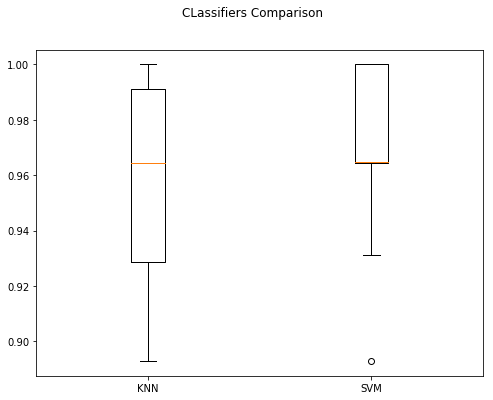

In [199]:
# boxplot algorithm comparison
import matplotlib.pyplot as plt
%matplotlib inline
%qtconsole
fig = plt.figure(figsize=(8,6))
fig.tight_layout()
fig.suptitle('CLassifiers Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Box and whisker plot showing the spread of the accuracy scores across each cross validation fold for each algorithm. 
* Boxplot for KNN mostly varies between 93% to 99% in some folds. 
* Boxplot for SVM shows accuracy range of 97% to 100% and contain an outlier of accuracy below than 90%. But it contain more accuracy value in higher range in most of folds

     **Therefore SVM is better choice.**